# **L2 norm on a test set**
Tale norma L2 viene presa come la norma massima 

In [1]:
# Pulizia
from IPython import get_ipython
get_ipython().run_line_magic('clear', '')
get_ipython().run_line_magic('reset', '-f')

# Import libraries:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import h5py
import sys
import os
import json

# Import user-defined libraries:
from FreeFEM import FFmatrix_fread, FFvector_fread
from solver_class import FiniteElementCylinderSolver, ReducedBasisCylinderSolver

In [2]:
import h5py

# Apri il file in modalità lettura
with h5py.File('checkpoint/step_190/matrici_RB.h5', 'r') as hf:
    # Accedi ai dataset e ricrea le matrici
    MM_RB = hf['MM_RB'][:]   #N_epsilon x N_epsilon
    FF_RB = hf['FF_RB'][:]   #N_epsilon x 1
    KK_RB = hf['KK_RB'][:]   #N_D+N_D x N_epsilon x N_epsilon
    AA_RB = hf['AA_RB'][:]   #N_epsilon
    ZZ_CO = hf['ZZ_CO'][:]   #N_D
    II_CO = hf['II_CO'][:]   #N_D x N_D

print(MM_RB.shape[1])
#dim = MM_RB.shape[1]

190


In [3]:
# # Define size of the test parameter set:
# FISSION_ENERGY = 3.215E-11
# sTR = 100

# # Define parameters ranges:
# MIN_FR, MAX_FR = 0.00, 5.00E+19        
# MIN_K, MAX_K =  0.9, 8.00    
# MIN_FY, MAX_FY = 0.00, 0.3
# MIN_LL, MAX_LL = 0.1E-3, 1.50E-3
# MIN_RR, MAX_RR = 0.75E-5, 2.00E-5
# MIN_BC, MAX_BC = 300, 2.5E+03                                                       

# # Compute a list of random parameters within the range:
# LIST_FR = np.random.uniform(low=MIN_FR, high=MAX_FR, size=(sTR))
# LIST_BC = np.random.uniform(low=MIN_BC, high=MAX_BC, size=(sTR))
# LIST_LL = np.random.uniform(low=MIN_LL, high=MAX_LL, size=(sTR))
# LIST_RR = np.random.uniform(low=MIN_RR, high=MAX_RR, size=(sTR))
# LIST_FY = np.random.uniform(low=MIN_FY, high=MAX_FY, size=(sTR))
# LIST_K = np.random.uniform(low=MIN_K, high=MAX_K, size=(sTR))
# np.savez('new algorithm/L2 errors/test_set.npz', FR=LIST_FR, BC=LIST_BC, LL=LIST_LL, RR=LIST_RR, FY=LIST_FY, K=LIST_K)

In [3]:
# import numpy as np 
loaded_data = np.load('L2 errors/test_set.npz')
LIST_FR = loaded_data['FR']
LIST_BC = loaded_data['BC']
LIST_LL = loaded_data['LL']
LIST_RR = loaded_data['RR']
LIST_FY = loaded_data['FY']
LIST_K = loaded_data['K']
# # LIST_GG = loaded_data['GG']

sTR = LIST_BC.shape[0]

## **L2 norm varying the number of modes**

In [4]:
# Inizializza il file e crea una lista vuota se non esiste
save_file = 'L2 errors/max_errors_L2.npy'
if os.path.exists(save_file):
    max_errors_L2 = np.load(save_file).tolist()  # Carica il file se già esiste
    start_dim = len(max_errors_L2)  # Dimensione già calcolata
else:
    max_errors_L2 = []
    start_dim = 0

total_dimensions = 190
dimensions = list(range(start_dim + 1, total_dimensions + 1))  # Genera le dimensioni da calcolare
print(f"Ripresa dalla dimensione: {start_dim + 1}")

MM_FO = np.load('model_files/XX_FO.npy', allow_pickle=True)[0]  # Matrice per norma L2
#with h5py.File('checkpoint/matrici_RB.h5', 'r') as hf:
#    # Accedi ai dataset e ricrea le matrici
#    ZZ_CO = hf['ZZ_CO'][:]
#    II_CO = hf['II_CO'][:]

# Itera sulle dimensioni delle basi ridotte
for dim in dimensions:
    max_L2_normalized_in_time = 0
    with h5py.File('checkpoint/step_190/matrici_RB.h5', 'r') as hf:
        basis = hf['basis'][:, :dim]

    # Itera sui set di parametri
    for i in range(sTR):
        cur_FR = LIST_FR[i]
        cur_BC = LIST_BC[i]
        cur_LL = LIST_LL[i]
        cur_RR = LIST_RR[i]
        cur_FY = LIST_FY[i]
        cur_K = LIST_K[i]
        cur_dt = 1.00E+04

        print(f"Iterazione {i+1}/{sTR} - Parametri: "
          f"FR={cur_FR:.2e}, BC={cur_BC:.2f}, LL={cur_LL:.2e}, "
          f"RR={cur_RR:.2e}, FY={cur_FY:.2f}, K={cur_K:.2f}")
    
        # Calcola la soluzione FOM 
        solver_FO = FiniteElementCylinderSolver()
        solver_FO.assemble(RADIUS=cur_RR, LENGTH=cur_LL, F_RATE=cur_FR, 
                        F_YIELD=cur_FY, T_BC=cur_BC, KTH=cur_K, dt=cur_dt)
        solution_FO = solver_FO.solve(n_steps=1000, verbose=False)   #(9900, 1001)

        # Calcola la soluzione ROM
        solver_RB = ReducedBasisCylinderSolver(basis[:, :])
        solver_RB.assemble(RADIUS=cur_RR, LENGTH=cur_LL, F_RATE=cur_FR, 
                        F_YIELD=cur_FY, T_BC=cur_BC, KTH=cur_K, dt=cur_dt)
        solution_RB = solver_RB.solve(n_steps=1000, error_bound=False)   #(173,1001)
        solution_RB = np.dot(basis, solution_RB[:, :])                   #(9900, 1001)
        
        #massimo errore in norma L2 nel tempo per un set di parametri per una dimensione dello spazio ridotto
        for ii in range(0, 1000):
            difference = solution_FO[:, ii] - solution_RB[:, ii]    #9900
            L2_norm = np.sqrt(MM_FO.dot(difference).dot(difference)) #1
            reference_norm = np.sqrt(MM_FO.dot(solution_FO[:, ii]).dot(solution_FO[:, ii])) #1
            L2_normalized = L2_norm / reference_norm # 1
            #Aggiorniamo l'errore massimo
            max_L2_normalized_in_time = max(max_L2_normalized_in_time, L2_normalized)   #non si presenta il problema dei nan
        #print(max_L2_normalized_in_time)  #combacia con quello salvato in max_errors_L2
    
    # Salva l'errore massimo per la dimensione corrente 
    max_errors_L2.append(max_L2_normalized_in_time)  #dopo aver runnato tutti i parametri salva il massimo assoluto. 
    print(f"Dim: {dim}, Max L2 normalized error: {max_L2_normalized_in_time}")

    np.save(save_file, max_errors_L2)
    print(f"Salvato errore per dimensione {dim}: {max_L2_normalized_in_time}")

print("Dimensioni delle basi:", dimensions)
print("Errori massimi normalizzati in norma L2:", max_errors_L2)

Ripresa dalla dimensione: 183
Iterazione 1/100 - Parametri: FR=2.86e+19, BC=2496.20, LL=7.71e-04, RR=1.70e-05, FY=0.22, K=2.54


/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_6934/3101755931.py:58: RuntimeWarning: invalid value encountered in scalar divide
  L2_normalized = L2_norm / reference_norm # 1


Iterazione 2/100 - Parametri: FR=2.78e+19, BC=2444.48, LL=1.41e-03, RR=8.91e-06, FY=0.30, K=7.16
Iterazione 3/100 - Parametri: FR=2.41e+19, BC=1618.31, LL=1.18e-04, RR=1.13e-05, FY=0.25, K=6.70
Iterazione 4/100 - Parametri: FR=3.74e+19, BC=732.27, LL=8.88e-04, RR=1.82e-05, FY=0.23, K=4.43
Iterazione 5/100 - Parametri: FR=2.11e+19, BC=773.57, LL=1.40e-03, RR=1.74e-05, FY=0.07, K=7.32
Iterazione 6/100 - Parametri: FR=1.35e+18, BC=689.34, LL=7.45e-04, RR=8.08e-06, FY=0.14, K=1.29
Iterazione 7/100 - Parametri: FR=1.23e+19, BC=839.13, LL=5.92e-04, RR=1.06e-05, FY=0.29, K=3.27
Iterazione 8/100 - Parametri: FR=1.51e+19, BC=1731.05, LL=1.01e-04, RR=1.14e-05, FY=0.06, K=5.10
Iterazione 9/100 - Parametri: FR=3.01e+19, BC=1454.64, LL=1.42e-03, RR=9.79e-06, FY=0.26, K=4.91
Iterazione 10/100 - Parametri: FR=4.89e+19, BC=946.50, LL=3.15e-04, RR=1.03e-05, FY=0.17, K=1.45
Iterazione 11/100 - Parametri: FR=5.42e+18, BC=2129.01, LL=1.08e-03, RR=1.81e-05, FY=0.12, K=5.03
Iterazione 12/100 - Parametri: FR

In [6]:
max_errors_L2 = np.load('L2 errors/max_errors_L2.npy').tolist()
dimensions = list(range(1, len(max_errors_L2) + 1))
print(dimensions)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190]


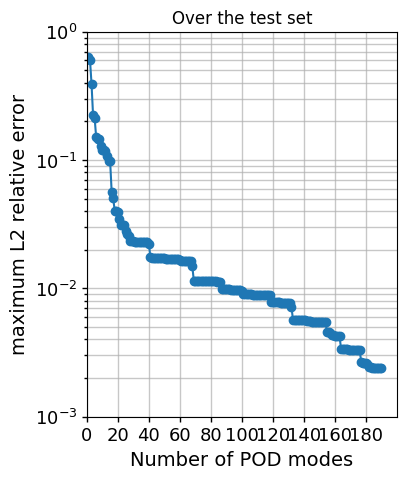

In [8]:
fig, (ax1) = plt.subplots(1, figsize=(4,5))
ax1.set_yscale('log')
ax1.plot(dimensions,max_errors_L2,  '-o')
ax1.tick_params(axis="y", which='both',labelsize=13,  width=1)
ax1.tick_params(axis='x', labelsize=13,  width=1)
ax1.set_xlabel('Number of POD modes',fontsize=14)
ax1.set_ylabel('maximum L2 relative error',fontsize=14)
#ax1.axvspan(1, NN, color='gray', alpha=0.2)
xticks = np.arange(0,200, 20)  
ax1.set_xticks(xticks)
ax1.set_xlim([0, 200])
ax1.set_ylim([1e-3, 1])
ax1.set_title(rf'Over the test set')
ax1.grid(visible=True, which='both', linewidth=1, alpha=0.7)
plt.savefig(os.path.join('plot/L2error.pdf'), bbox_inches='tight')

## **L2 norm in time**

In [5]:
dimensions = [190]
#list(range(1, 3))  # Da 1 a 57
t_final = 1.00E+06  # [s]
cur_dt = 20  # [s]
num_time_steps = int(t_final / cur_dt)  # [-]
L2_error_in_time = np.zeros(num_time_steps)           #vettore dell'errore in norma L2 nel tempo per quel specifico parametro
L2_error_in_time_for_dim = np.zeros(num_time_steps)   #vettore dell'errore in norma L2 nel tempo che risulta essere il massimo per quel numero di basis
max_L2_error_for_dim = 0                              #valore massimo che viene confrontato 
sTR = 10

MM_FO = np.load('model_files/XX_FO.npy', allow_pickle=True)[0]  # Matrice per norma L2
#with h5py.File('new algorithm/checkpoint/step_190/matrici_RB.h5', 'r') as hf:
    # Accedi ai dataset e ricrea le matrici
    #ZZ_CO = hf['ZZ_CO'][:]
    #II_CO = hf['II_CO'][:]

for dim in dimensions:
    max_L2_error_for_dim = 0 
    with h5py.File('checkpoint/step_190/matrici_RB.h5', 'r') as hf:
        basis = hf['basis'][:, :dim]

    # Itera sui set di parametri
    for i in range(sTR):
        cur_FR = LIST_FR[i]
        cur_BC = LIST_BC[i]
        cur_LL = LIST_LL[i]
        cur_RR = LIST_RR[i]
        cur_FY = LIST_FY[i]
        cur_K = LIST_K[i]
        #cur_dt = 20 #1.00E+04

        print(f"Iterazione {i+1}/{sTR} - Parametri: "
            f"FR={cur_FR:.2e}, BC={cur_BC:.2f}, LL={cur_LL:.2e}, "
            f"RR={cur_RR:.2e}, FY={cur_FY:.2f}, K={cur_K:.2f}")

        # Calcola la soluzione FOM con i parametri attuali
        solver_FO = FiniteElementCylinderSolver()
        solver_FO.assemble(RADIUS=cur_RR, LENGTH=cur_LL, F_RATE=cur_FR, 
                        F_YIELD=cur_FY, T_BC=cur_BC, KTH=cur_K, dt=cur_dt)
        solution_FO = solver_FO.solve(n_steps=num_time_steps, verbose=False)         #(9900, 1001)

        # Calcola la soluzione ROM
        solver_RB = ReducedBasisCylinderSolver(basis[:, :])
        solver_RB.assemble(RADIUS=cur_RR, LENGTH=cur_LL, F_RATE=cur_FR, 
                        F_YIELD=cur_FY, T_BC=cur_BC, KTH=cur_K, dt=cur_dt)
        solution_RB = solver_RB.solve(n_steps=num_time_steps, error_bound=False)     #(173,1001)
        solution_RB = np.dot(basis, solution_RB[:, :])                               #(9900, 1001)

        for ii in range(0, num_time_steps):
            difference = solution_FO[:, ii] - solution_RB[:, ii]
            L2_norm = np.sqrt(MM_FO.dot(difference).dot(difference)) #1
            reference_norm = np.sqrt(MM_FO.dot(solution_FO[:, ii]).dot(solution_FO[:, ii])) #1
            L2_normalized = L2_norm / reference_norm # 1
            L2_error_in_time[ii] = L2_normalized                                     #Mi salvo il vettore dell'errore in norma L2 nel tempo per quel set di parametri e dimensione
 
        
        if np.nanmax(L2_error_in_time) > max_L2_error_for_dim: 
            max_L2_error_for_dim = np.nanmax(L2_error_in_time)
            L2_error_in_time_for_dim = L2_error_in_time.copy()             #vettore nel tempo dell'errore in norma L2 che risulta essere massimo rispetto ai set di parametri

        print("\n")
     
    np.savetxt(f"L2 errors - check time step/L2_error_in_time_with_{dim}_basis.csv", L2_error_in_time_for_dim, delimiter=",")

Iterazione 1/10 - Parametri: FR=2.86e+19, BC=2496.20, LL=7.71e-04, RR=1.70e-05, FY=0.22, K=2.54


/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_2254/3390423579.py:53: RuntimeWarning: invalid value encountered in scalar divide
  L2_normalized = L2_norm / reference_norm # 1




Iterazione 2/10 - Parametri: FR=2.78e+19, BC=2444.48, LL=1.41e-03, RR=8.91e-06, FY=0.30, K=7.16


Iterazione 3/10 - Parametri: FR=2.41e+19, BC=1618.31, LL=1.18e-04, RR=1.13e-05, FY=0.25, K=6.70


Iterazione 4/10 - Parametri: FR=3.74e+19, BC=732.27, LL=8.88e-04, RR=1.82e-05, FY=0.23, K=4.43


Iterazione 5/10 - Parametri: FR=2.11e+19, BC=773.57, LL=1.40e-03, RR=1.74e-05, FY=0.07, K=7.32


Iterazione 6/10 - Parametri: FR=1.35e+18, BC=689.34, LL=7.45e-04, RR=8.08e-06, FY=0.14, K=1.29


Iterazione 7/10 - Parametri: FR=1.23e+19, BC=839.13, LL=5.92e-04, RR=1.06e-05, FY=0.29, K=3.27


Iterazione 8/10 - Parametri: FR=1.51e+19, BC=1731.05, LL=1.01e-04, RR=1.14e-05, FY=0.06, K=5.10


Iterazione 9/10 - Parametri: FR=3.01e+19, BC=1454.64, LL=1.42e-03, RR=9.79e-06, FY=0.26, K=4.91


Iterazione 10/10 - Parametri: FR=4.89e+19, BC=946.50, LL=3.15e-04, RR=1.03e-05, FY=0.17, K=1.45




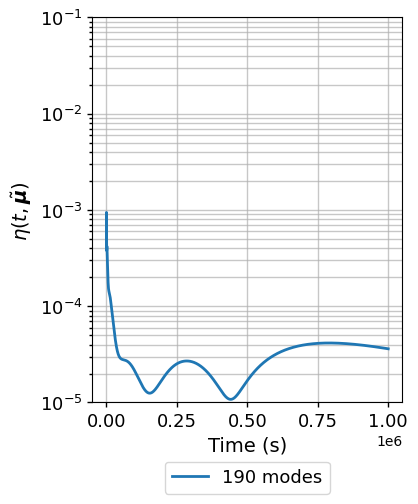

In [7]:
# data_1 = np.loadtxt("L2 errors/L2_error_in_time_with_1_basis.csv", delimiter=",")  
# data_2 = np.loadtxt("L2 errors/L2_error_in_time_with_2_basis.csv", delimiter=",")      
# data_3 = np.loadtxt("L2 errors/L2_error_in_time_with_3_basis.csv", delimiter=",")  
# data_4 = np.loadtxt("L2 errors/L2_error_in_time_with_4_basis.csv", delimiter=",")  
# data_5 = np.loadtxt("L2 errors/L2_error_in_time_with_5_basis.csv", delimiter=",")     
# data_6 = np.loadtxt("L2 errors/L2_error_in_time_with_6_basis.csv", delimiter=",")  
# data_10 = np.loadtxt("L2 errors/L2_error_in_time_with_10_basis.csv", delimiter=",")      
# data_20 = np.loadtxt("L2 errors/L2_error_in_time_with_20_basis.csv", delimiter=",")      
# data_25 = np.loadtxt("L2 errors/L2_error_in_time_with_25_basis.csv", delimiter=",")       
# data_50 = np.loadtxt("L2 errors/L2_error_in_time_with_50_basis.csv", delimiter=",")    
# data_75 = np.loadtxt("L2 errors/L2_error_in_time_with_75_basis.csv", delimiter=",")       
# data_100 = np.loadtxt("L2 errors/L2_error_in_time_with_100_basis.csv", delimiter=",") 
# data_150 = np.loadtxt("L2 errors/L2_error_in_time_with_150_basis.csv", delimiter=",")       
# data_190 = np.loadtxt("L2 errors/L2_error_in_time_with_190_basis.csv", delimiter=",")       

data_190 = np.loadtxt("L2 errors - check time step/L2_error_in_time_with_190_basis.csv", delimiter=",")     


time = np.linspace(0, t_final, num_time_steps)

fig, (ax1) = plt.subplots(1, figsize=(4,5))
ax1.set_yscale('log')
#ax1.plot(time, data_1, label='1 mode', linewidth=2)  
#ax1.plot(time,data_2, label='2 mode', linewidth = 2)
#ax1.plot(time, data_3, label='3 mode', linewidth=2)  
#ax1.plot(time, data_4, label='4 mode', linewidth=2)  
#ax1.plot(time, data_5, label='5 modes', linewidth=2)
#ax1.plot(time, data_6, label='6 mode', linewidth=2)  
# ax1.plot(time,data_10, label='10 mode', linewidth = 2)
# ax1.plot(time,data_20, label='20 mode', linewidth = 2)
# ax1.plot(time,data_25, label='25 modes', linewidth = 2)
# ax1.plot(time,data_50, label='50 modes', linewidth = 2)
# ax1.plot(time,data_75, label='75 modes', linewidth = 2)
# ax1.plot(time,data_100, label='100 modes', linewidth = 2)
# ax1.plot(time,data_150, label='150 modes', linewidth = 2)
ax1.plot(time,data_190, label='190 modes', linewidth = 2)


ax1.tick_params(axis="y", which='both',labelsize=13,  width=1)
ax1.tick_params(axis='x', labelsize=13,  width=1)
ax1.set_xlabel('Time (s)',fontsize=14)
ax1.set_ylabel(r'$\eta (t, \tilde{\boldsymbol{\mu}})$',fontsize=14)
#ax1.set_xlim([0,1e7])
ax1.set_ylim([1e-5, 1e-1])
#ax1.set_title(rf'Over the test set')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=3, fontsize=13)
ax1.grid(visible=True, which='both', linewidth=1, alpha=0.7)
plt.savefig('plot/L2error_in_time.pdf', bbox_inches='tight') 

## **Computational cost vs error**

In [9]:
# Pulizia
#from IPython import get_ipython
#get_ipython().run_line_magic('clear', '')
#get_ipython().run_line_magic('reset', '-f')

# Import libraries:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import h5py
import sys
import os
import json
import time

In [10]:
# Lettura dei parametri dal file JSON
with open("reference case/Reference_parameters.json", "r") as json_file:
    parameters = json.load(json_file)
FISSION_ENERGY = parameters["FISSION_ENERGY"]                       
FISSION_RATE = parameters["FISSION_RATE"]                   
RADIUS = parameters["RADIUS"]
LENGTH = parameters["LENGTH"]
FISSION_YIELD = parameters["FISSION_YIELD"]                 
FUEL_THERMAL_CONDUCTIVITY = parameters["FUEL_THERMAL_CONDUCTIVITY"]
T_BC = parameters["T_BC"]  
TIME_FINAL = 1.00E+07
TIME_DELTA = 1.00E+04

In [28]:
solver_FO = FiniteElementCylinderSolver()
solver_FO.assemble(F_YIELD=FISSION_YIELD, F_RATE=FISSION_RATE, T_BC=T_BC, LENGTH=LENGTH, RADIUS=RADIUS, dt=TIME_DELTA)
t0 = time.time()
#for ii in range(25):
#    solution_FO = solver_FO.solve(n_steps=1000, verbose=False)
#time_FO = (time.time() - t0)/25
time_FO = 0.98
print(rf'FO elapsed time = {time_FO:.5f} seconds')

FO elapsed time = 0.98000 seconds


In [30]:
with h5py.File('checkpoint/step_190/matrici_RB.h5', 'r') as hf:
    basis = hf['basis'][:,:]  
print(basis.shape)

savings_file = 'L2 errors/computational_savings.npy'
if os.path.exists(savings_file):
    computational_savings = np.load(savings_file).tolist()  # Carica i dati esistenti
    start_dim = len(computational_savings)  # Determina da dove ripartire
    print(f"Ripartenza dalla dimensione {start_dim + 1}")
else:
    computational_savings = []  # Se il file non esiste, inizia con una lista vuota
    start_dim = 0  # Nessuna dimensione calcolata all'inizio

total_dimensions = 190
dimensions = list(range(start_dim + 1, total_dimensions + 1))  # Genera le dimensioni da calcolare
print(f"Ripresa dalla dimensione: {start_dim + 1}")

for dim in dimensions:
    solver_RB = ReducedBasisCylinderSolver(basis[:, :dim])
    solver_RB.assemble(F_YIELD=FISSION_YIELD, F_RATE=FISSION_RATE, T_BC=T_BC, LENGTH=LENGTH, RADIUS=RADIUS, dt=TIME_DELTA)
    t0 = time.time()
    for ii in range(100):
        solution_RB = solver_RB.solve(n_steps=1000, error_bound=False)
    time_RB =(time.time() - t0)/100
    print(rf'RB elapsed time = {time_RB:.5f}')
    ratio = time_RB/time_FO
    savings = 1 / ratio
    computational_savings.append(savings)
    np.save(savings_file, computational_savings)
    print(f"Dim: {dim}, Computational savings: {savings}")


(9900, 190)
Ripresa dalla dimensione: 1
RB elapsed time = 0.00344
Dim: 1, Computational savings: 284.47117755632956
RB elapsed time = 0.00379
Dim: 2, Computational savings: 258.37125242630566
RB elapsed time = 0.00359
Dim: 3, Computational savings: 273.1570367003327
RB elapsed time = 0.00352
Dim: 4, Computational savings: 278.69866516234407
RB elapsed time = 0.00336
Dim: 5, Computational savings: 291.2965004744603
RB elapsed time = 0.00409
Dim: 6, Computational savings: 239.6021446583481
RB elapsed time = 0.00357
Dim: 7, Computational savings: 274.4261451453209
RB elapsed time = 0.00369
Dim: 8, Computational savings: 265.7619558091208
RB elapsed time = 0.00415
Dim: 9, Computational savings: 236.0620085054085
RB elapsed time = 0.00357
Dim: 10, Computational savings: 274.85388888740295
RB elapsed time = 0.00375
Dim: 11, Computational savings: 261.1966623604313
RB elapsed time = 0.00376
Dim: 12, Computational savings: 260.3571990947331
RB elapsed time = 0.00389
Dim: 13, Computational savi

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 4

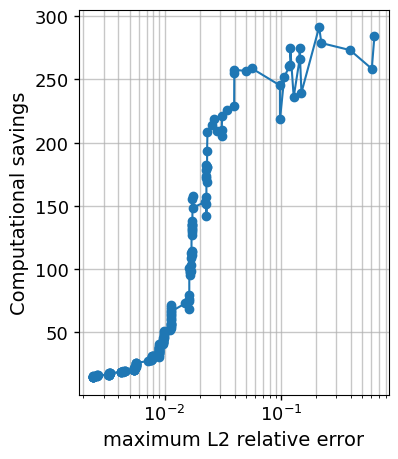

In [34]:
max_errors_L2 = np.load('L2 errors/max_errors_L2.npy').tolist()
dimensions = list(range(1, len(max_errors_L2) + 1))
print(dimensions)
computational_savings = np.load(savings_file).tolist()
dimensions = list(range(1, len(computational_savings) + 1))
print(dimensions)


fig, (ax1) = plt.subplots(1, figsize=(4,5))
ax1.set_xscale('log')
ax1.plot(max_errors_L2,computational_savings, '-o')
ax1.tick_params(axis="y", which='both',labelsize=13,  width=1)
ax1.tick_params(axis='x', labelsize=13,  width=1)
ax1.set_xlabel('maximum L2 relative error',fontsize=14)
ax1.set_ylabel('Computational savings',fontsize=14)
#ax1.axvspan(1, NN, color='gray', alpha=0.2)
#xticks = np.arange(0,200, 20)  
#ax1.set_xticks(xticks)
#ax1.set_xlim([1e-5, 1])
ax1.grid(visible=True, which='both', linewidth=1, alpha=0.7)
plt.savefig(os.path.join('plot/computational savings.pdf'), bbox_inches='tight')